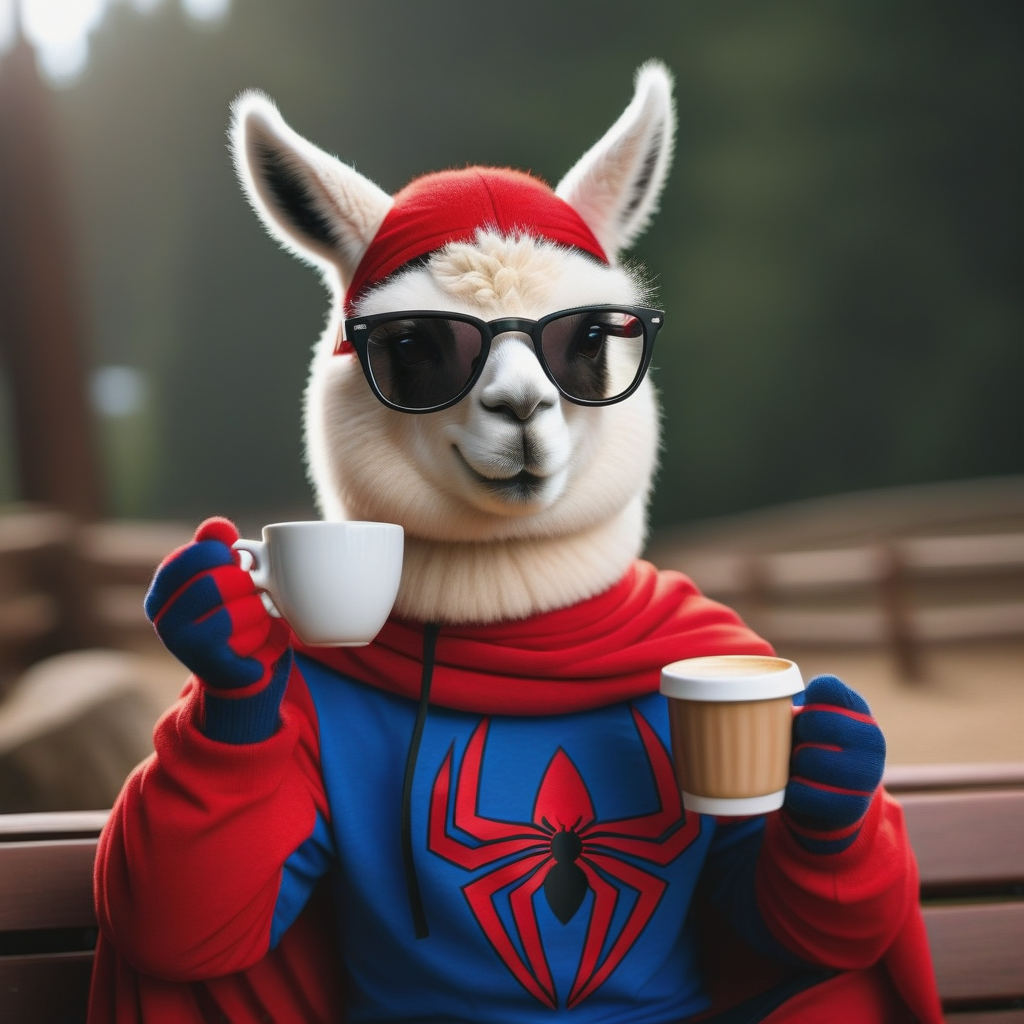

## 📦 Packages and Basic Setup
---

To run the notebooks you'll need two secrets named `W&B` and `HF_TOKEN`. Also, in the configuration section change the `wandb_entity` to your username/workspace.

In [ ]:
%%capture
!pip install -q -U bitsandbytes datasets evaluate ml-collections seqeval wandb
!pip install -q git+https://github.com/huggingface/peft.git

In [ ]:
import evaluate
import numpy as np
from transformers import AutoTokenizer
from datasets import ClassLabel, load_dataset
from transformers import TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from transformers import DataCollatorForTokenClassification

In [ ]:
import wandb
wandb.login()

In [ ]:
# @title ⚙️ Configuration

import ml_collections

def get_config() -> ml_collections.ConfigDict:
  config = ml_collections.ConfigDict()
  config.model = "unsloth/llama-2-7b-bnb-4bit" # @param {type: "string"}
  config.lora_r = 4  # @param {type: "number"}
  config.lora_alpha = 32  # @param {type: "number"}
  config.lora_dropout = 0.1  # @param {type: "number"}
  config.max_length = 32  # @param {type: "number"}
  config.batch_size = 16  # @param {type: "number"}
  config.num_epochs = 5 # @param {type: "number"}
  config.learning_rate = 1e-3 # @param {type: "number"}
  config.dataset = "conll2003" # @param {type: "string"}
  config.wandb_entity = "sauravmaheshkar" # @param {type: "string"}
  return config

config = get_config()

In [ ]:
import os
import wandb

wandb.init(
  project="Llama-NER",
  job_type="train",
  group=config.model,
  config = config.to_dict(),
  entity=config.wandb_entity,
)

os.environ["WANDB_WATCH"]="false"
os.environ["WANDB_LOG_MODEL"]="false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 💿 The Dataset
---

In [ ]:
%%capture
ds = load_dataset(
  config.dataset,
  cache_dir="/cache/",
)

seqeval = evaluate.load("seqeval")

In [ ]:
column_names = ds["train"].column_names
features = ds["train"].features

text_column_name = "tokens"
label_column_name = "ner_tags"

label_list = features[label_column_name].feature.names
label2id = {i: i for i in range(len(label_list))}
id2label = {v: k for k, v in label2id.items()}

## 🖖 Utility Functions
---

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## 🏠 Model Architecture
---

### Implementating `LlamaForTokenClassification`

[Source: @KoichiYasuoka](https://github.com/huggingface/transformers/issues/26521#issuecomment-1868284434)

In [ ]:
%%capture
from typing import List, Optional, Tuple, Union
import torch
from torch import nn
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.file_utils import add_start_docstrings_to_model_forward
from transformers.models.llama.modeling_llama import LlamaModel, LlamaPreTrainedModel, LLAMA_INPUTS_DOCSTRING

class LlamaForTokenClassification(LlamaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.model = LlamaModel(config)
        if hasattr(config, "classifier_dropout") and config.classifier_dropout is not None:
            classifier_dropout = config.classifier_dropout
        elif hasattr(config, "hidden_dropout") and config.hidden_dropout is not None:
            classifier_dropout = config.hidden_dropout
        else:
            classifier_dropout = 0.1
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = transformer_outputs[0]
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + transformer_outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions
        )

tokenizer = AutoTokenizer.from_pretrained(config.model)

model = LlamaForTokenClassification.from_pretrained(
  config.model,
  num_labels=len(label_list),
  id2label=id2label,
  label2id=label2id,
  cache_dir="/cache/",
)

### Process Dataset for Token Classification

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True, padding='longest', max_length=config.max_length, truncation=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

### Obtaining 🤗 PEFT Model

In [ ]:
peft_config = LoraConfig(
  task_type=TaskType.TOKEN_CLS,
  inference_mode=False,
  r=config.lora_r,
  lora_alpha=config.lora_alpha,
  lora_dropout=config.lora_dropout
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

## ✍️ Training
---

In [ ]:
training_args = TrainingArguments(
    output_dir="unsloth-llama-2-7b-bnb-4bit-conll2003",
    learning_rate=config.learning_rate,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.num_epochs,
    logging_steps=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to=["wandb"],
    optim="paged_adamw_8bit",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()

In [ ]:
wandb.config.train_results = train_results
wandb.finish()

## 📚 References

* Github: [`4AI/LS-LLaMA`](https://github.com/4AI/LS-LLaMA)
* [Alpaca + Llama 7b example by `@unslothai`](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)